In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from itertools import product
import numpy as np
import pandas as pd
from kerasdcgan.etl import read_etl6_data, data2array
from kerasdcgan.models import DCGAN

Using TensorFlow backend.


### Auxiliary functions

In [3]:
def plot_images(images, filename=None, cols=4, figsize=(10, 10)):
    
    rows = np.ceil(len(images)/cols)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(np.squeeze(image), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

def series_to_string(series):
    string = series.to_string().split('\n')
    string = [': '.join(s.split()) for s in string]
    string = '    '.join(string)
    return string

### Build DCGAN model

#### DCGAN parameters

In [4]:
input_dim = 100

In [5]:
dcgan = DCGAN(g_input_dim=input_dim)
dcgan.build()
dcgan.summary()

Generator model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0   

### Train DCGAN

#### Read training data

In [6]:
data = read_etl6_data('/root/share/personal/data/ETL/ETL6/')
x_all, y_all = data2array(data, new_shape=(28, 28), norm_factor=255.0, expand_dims=True)

katakana = [''.join(e) for e in product(' KSTNHMYRW', 'AIUEO')] + [' N']  # Includes obsolete characters
katakana_idx = [i for i, label in enumerate(y_all) if label in katakana]
x_train = x_all[katakana_idx]

#### Fixed noise vectors to check generator

In [10]:
check_samples = 16
noise_samples = np.random.uniform(low=-1.0, high=1.0, size=(check_samples, input_dim))

#### (optional) Pre-train adversarial discriminator

In [9]:
dcgan.pretrain(x_test, batch_size=256, epochs=1)

Epoch 1/1
20000/20000 [==============================] - 10s - loss: 0.1814 - acc: 0.9399     

#### Main training loop

In [11]:
steps = 1000
batch_size = 256

In [13]:
df = pd.DataFrame(columns=['ad_loss', 'ad_acc', 'stacked_loss', 'stacked_acc'])

for step in range(steps):
    idx = np.random.randint(0, x_train.shape[0], size=batch_size)
    ad_metrics, stacked_metrics = dcgan.train_on_batch(x_train[idx], freeze_discriminator=False)
    
    df.loc[step, ['ad_loss', 'ad_acc']] = ad_metrics
    df.loc[step, ['stacked_loss', 'stacked_acc']] = stacked_metrics
    string = df.loc[step].to_string().replace('    ',':').replace('\n', '    ')
    
    if step % 500 == 0:
        print(step, series_to_string(df.loc[step]))
        filename = 'fake_images_%s.png' % str(step).zfill(6)
        generated_images = dcgan.generate(noise_samples)
        plot_images(generated_images, filename)

0 ad_loss: 0.692474    ad_acc: 0.527344    stacked_loss: 0.942652    stacked_acc: 0
500 ad_loss: 0.681148    ad_acc: 0.589844    stacked_loss: 0.984683    stacked_acc: 0.0429688


### Generate images

In [21]:
generated_images = dcgan.generate(16)

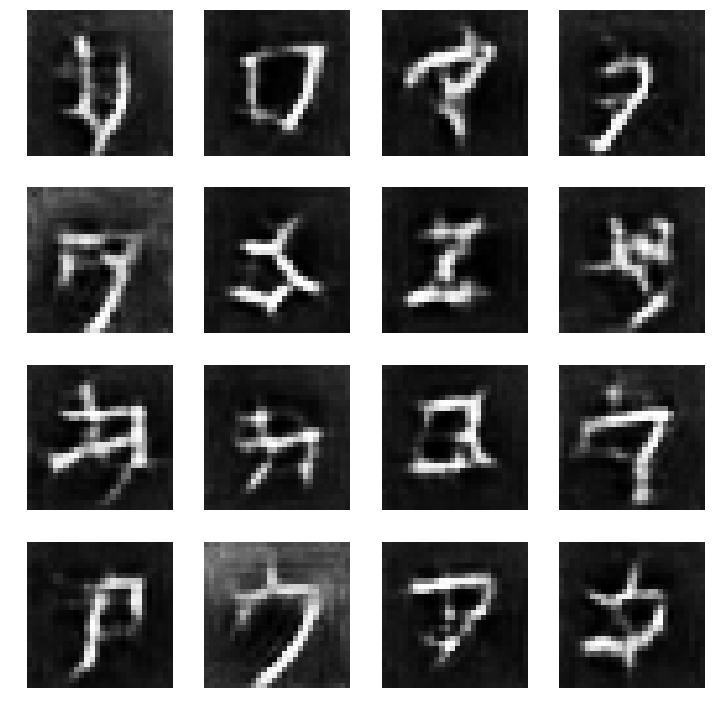

In [22]:
plot_images(generated_images)

### Plot loss/accuracy progress

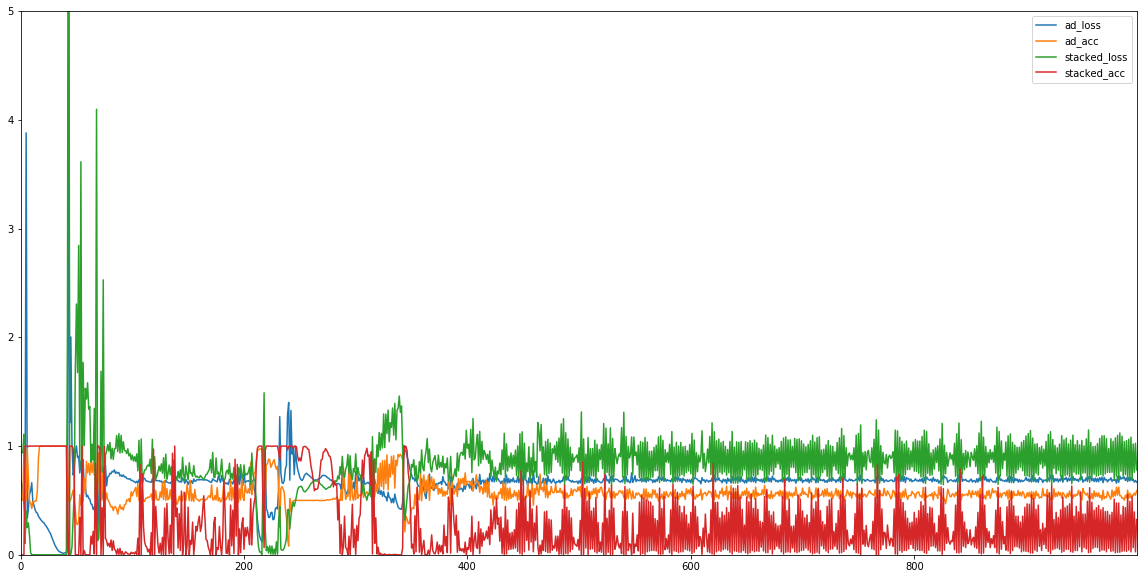

In [18]:
df.plot(figsize=(20, 10))
plt.ylim([0, 5])
plt.show()